In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import warnings


In [2]:
train_Mortgage = pd.read_csv('train_Mortgage.csv')
val_Mortgage = pd.read_csv('val_Mortgage.csv')
train_Pension = pd.read_csv('train_Pension.csv')
val_Pension = pd.read_csv('val_Pension.csv')
train_Savings = pd.read_csv('train_Savings.csv')
val_Savings = pd.read_csv('val_Savings.csv')

In [3]:
train_Mortgage.head()

,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,Mortgage
0,43,15,43,0,0,0,0,45,38012,3,13,24,4,0,0,0,6,47,0.000,0
1,44,14,44,0,0,0,0,51,45479,7,6,12,3,1,0,0,8,39,0.000,0
2,25,0,25,1,0,0,0,52,31515,3,-1,0,3,5,0,0,12,34,0.000,0
3,40,5,40,1,0,0,0,69,30782,3,27,36,0,0,0,0,11,18,0.000,0
4,33,4,33,0,0,0,0,46,39377,5,33,36,3,2,4,2,14,38,8.585,0


для начала создадим param_grid для поиска наилучших параметров

In [4]:
models = {
      "Logistic Regression": LogisticRegression(),
}
param_grids = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "solver": ["liblinear", "lbfgs"],
        "max_iter": [500, 1000]
    },
}

теперь обучим модели четырёх видов логистической регрессии. Их можно будет посмотреть в словаре models_mortgage

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt

def train_and_evaluate_models(train, val, s):

    X_train = train.drop(columns=[s])
    y_train = train[s]
    X_val = val.drop(columns=[s])
    y_val = val[s]

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)


    trained_models = {}
    for model_name, model in models.items():
        print(f"Обучение модели: {model_name}")

        if model_name == "Polynomial Logistic Regression":
            poly = PolynomialFeatures(degree=2)
            X_train_poly = poly.fit_transform(X_train_scaled)
            X_val_poly = poly.transform(X_val_scaled)
            grid_search = GridSearchCV(model, param_grids["Logistic Regression"], cv=5, scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X_train_poly, y_train)
        else:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)

        best_params = grid_search.best_params_
        print(f"Лучшие параметры для {model_name}: {best_params}")

        best_model = grid_search.best_estimator_

        if model_name == "Polynomial Logistic Regression":
            y_val_pred_proba = best_model.predict_proba(X_val_poly)[:, 1]
        else:
            y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

        roc_auc = roc_auc_score(y_val, y_val_pred_proba)
        print(f"ROC-AUC для {model_name}: {roc_auc:.4f}")

        fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

        trained_models[model_name] = {
            'model': best_model,
            'best_params': best_params,
            'roc_auc': roc_auc
        }


    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    return trained_models

Обучение модели: Logistic Regression
Лучшие параметры для Logistic Regression: {'C': 0.001, 'max_iter': 500, 'solver': 'lbfgs'}
ROC-AUC для Logistic Regression: 0.7787


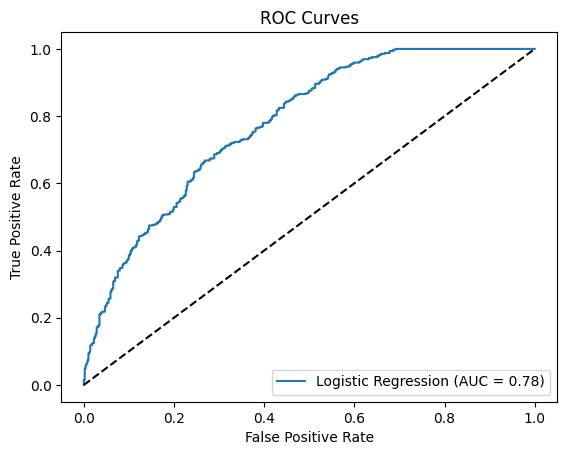

In [6]:
models_Pension = train_and_evaluate_models(train_Pension, val_Pension, "Pension")

Обучение модели: Logistic Regression
Лучшие параметры для Logistic Regression: {'C': 0.1, 'max_iter': 500, 'solver': 'lbfgs'}
ROC-AUC для Logistic Regression: 0.6928


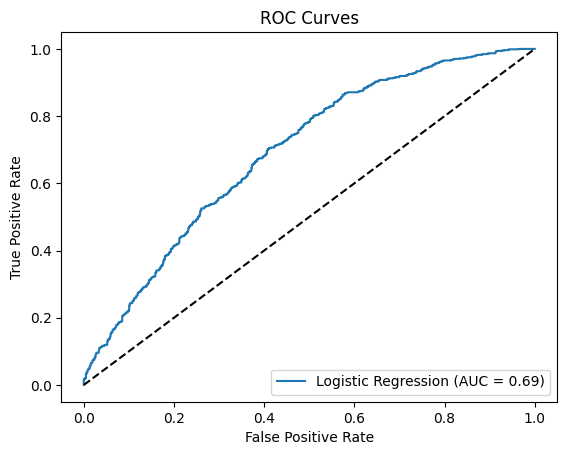

In [7]:
models_Savings = train_and_evaluate_models(train_Savings, val_Savings, "Savings")

Обучение модели: Logistic Regression
Лучшие параметры для Logistic Regression: {'C': 0.01, 'max_iter': 500, 'solver': 'lbfgs'}
ROC-AUC для Logistic Regression: 0.9382


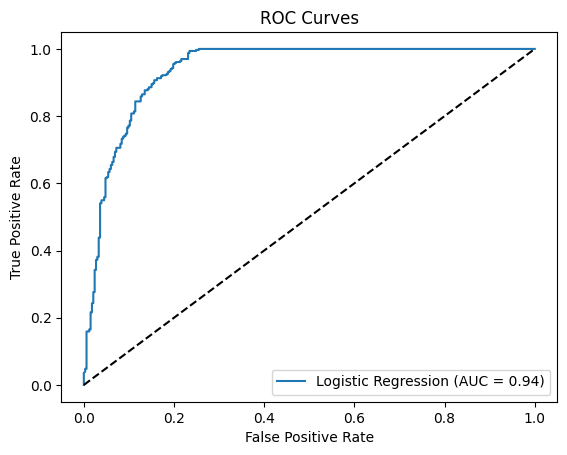

In [8]:
models_Mortgage = train_and_evaluate_models(train_Mortgage, val_Mortgage, "Mortgage")

теперь сохраним модели

In [9]:
print(models_Mortgage)

{'Logistic Regression': {'model': LogisticRegression(C=0.01, max_iter=500), 'best_params': {'C': 0.01, 'max_iter': 500, 'solver': 'lbfgs'}, 'roc_auc': np.float64(0.9382039697355012)}}


наконец, пропытаемся определить значимость параметров модели, для этого создадим функцию, визуализирующую значимость признаков

In [10]:
train_Mortgage.head(5)

,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,Mortgage
0,43,15,43,0,0,0,0,45,38012,3,13,24,4,0,0,0,6,47,0.000,0
1,44,14,44,0,0,0,0,51,45479,7,6,12,3,1,0,0,8,39,0.000,0
2,25,0,25,1,0,0,0,52,31515,3,-1,0,3,5,0,0,12,34,0.000,0
3,40,5,40,1,0,0,0,69,30782,3,27,36,0,0,0,0,11,18,0.000,0
4,33,4,33,0,0,0,0,46,39377,5,33,36,3,2,4,2,14,38,8.585,0


<ipython-input-15-f9d38cf4fd19>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df, palette=colors)
<ipython-input-15-f9d38cf4fd19>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df, palette=colors)
<ipython-input-15-f9d38cf4fd19>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df, palette=colors)


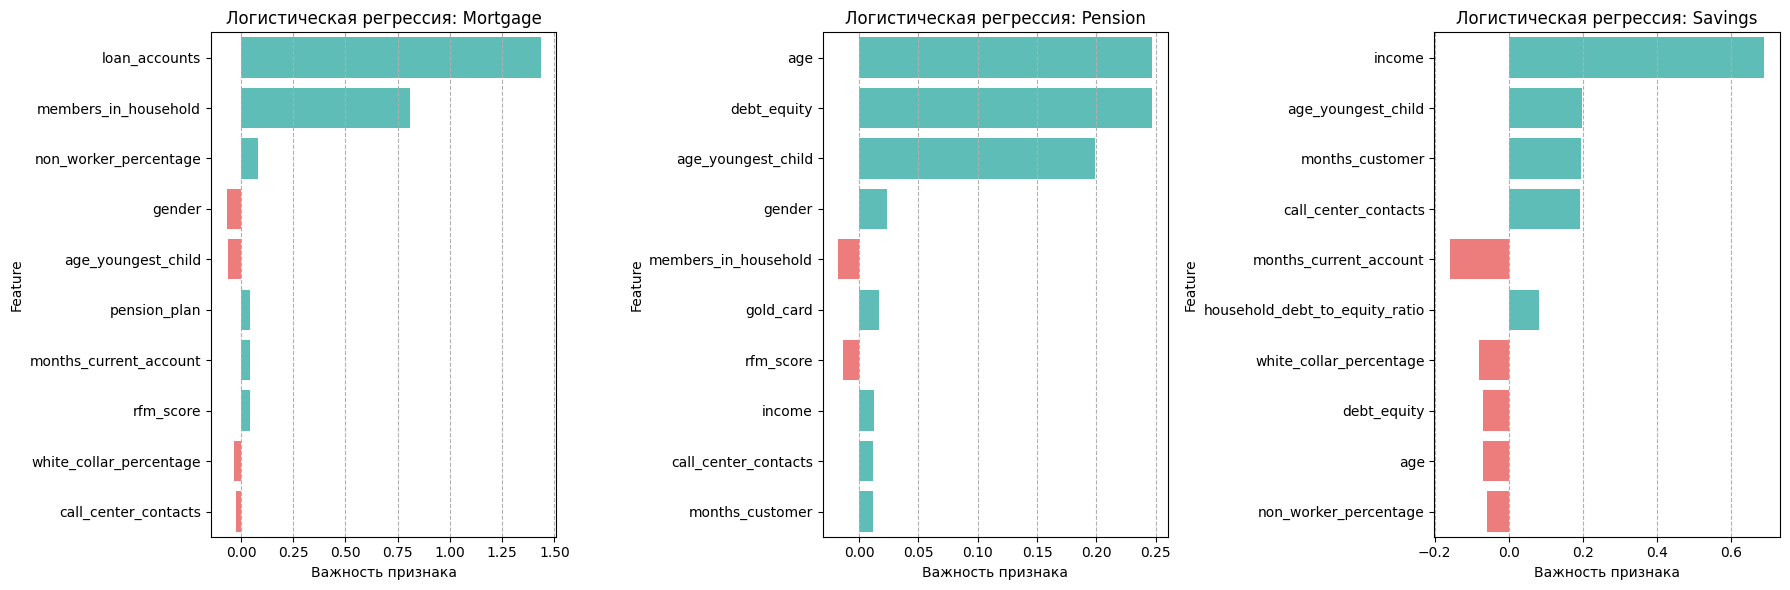

Сводная таблица стабильности:
                               |Важность|                         Знак  \
Продукт                          Mortgage   Pension   Savings Mortgage   
Признак                                                                  
loan_accounts                    1.434711  0.004708  0.016004        +   
members_in_household             0.806631  0.017337  0.043726        +   
non_worker_percentage            0.080900  0.002950  0.059425        +   
gender                           0.069140  0.023270  0.013091        -   
age_youngest_child               0.060698  0.198887  0.197283        -   
pension_plan                     0.044445  0.005462  0.015295        +   
months_current_account           0.041249  0.009781  0.158122        +   
rfm_score                        0.040877  0.013151  0.024824        +   
white_collar_percentage          0.032689  0.010414  0.079137        -   
call_center_contacts             0.024253  0.011735  0.191815        -   
number_p

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def load_features(product):
    train = pd.read_csv(f'train_{product}.csv')
    features = train.drop(product, axis=1).columns.tolist()
    return features

products = ["Mortgage", "Pension", "Savings"]
models_dict = {
    "Mortgage": globals()["models_Mortgage"],
    "Pension": globals()["models_Pension"],
    "Savings": globals()["models_Savings"]
}

feature_data = {}
for product in products:
    try:
        model = models_dict[product]["Logistic Regression"]["model"]
        coefficients = model.coef_[0]
        features = load_features(product)

        if len(features) != len(coefficients):
            raise ValueError(
                f"Несоответствие для {product}: "
                f"Признаков {len(features)}, коэффициентов {len(coefficients)}"
            )

        feature_data[product] = {
            "features": features,
            "coefs": coefficients
        }

    except Exception as e:
        print(f"Ошибка в {product}: {str(e)}")
        continue


plt.figure(figsize=(18, 6))
for idx, product in enumerate(products, 1):
    if product not in feature_data:
        continue

    data = feature_data[product]
    df = pd.DataFrame({
        "Feature": data["features"],
        "Importance": data["coefs"]
    }).sort_values("Importance", key=abs, ascending=False).head(10)

    plt.subplot(1, 3, idx)
    colors = ["#FF6B6B" if v < 0 else "#4ECDC4" for v in df["Importance"]]
    sns.barplot(x="Importance", y="Feature", data=df, palette=colors)
    plt.title(f"Логистическая регрессия: {product}")
    plt.xlabel("Важность признака")
    plt.grid(axis="x", linestyle="--")

plt.tight_layout()
plt.show()


stability_data = []
for product in products:
    if product not in feature_data:
        continue

    data = feature_data[product]
    for feature, coef in zip(data["features"], data["coefs"]):
        stability_data.append({
            "Признак": feature,
            "Продукт": product,
            "Знак": "+" if coef > 0 else "-",
            "|Важность|": abs(coef)
        })

stability_df = pd.DataFrame(stability_data)
pivot_table = stability_df.pivot_table(
    index="Признак",
    columns="Продукт",
    values=["Знак", "|Важность|"],
    aggfunc={"Знак": "first", "|Важность|": "max"}
)

print("Сводная таблица стабильности:")
print(pivot_table.dropna(how="all").sort_values(by=("|Важность|", "Mortgage"), ascending=False))

common_features = set()
for product in products:
    if product in feature_data:
        features = set(feature_data[product]["features"])
        common_features = features if not common_features else common_features & features

print("\nОбщие признаки для всех продуктов:", common_features)